# Smoothing particles

In [1]:
# Libraries ----
import sys  # type: ignore
import warnings

import imageio  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append("../modules")
import plot_clustering as plt_cp  # type: ignore
import plot_smoothing as plt_sp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import smoothing_particles as sp  # type: ignore
import track_particles as tp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

ordering = True
video_name = "3n_3m_0f_240216_1"
n_particles = int(video_name[0])
save_figures = True
x_bounds = [0, 1080]
y_bounds = [70, 1850]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Load tracked data

In [3]:
df_tracked = pd.read_csv(
    "{}/clustered_{}.csv".format(output_path, video_name), low_memory=False
)
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,340.411926,120.340292,349.157329,118.204013,NaN,340.411926,120.340292,NaN,340.411926,120.340292,1.164580,15328.0,250.896093,84.714567,0.941272,3,NaN,NaN,NaN,NaN,False,False,False
1,1,0,1639.166653,140.120752,1635.666768,141.355125,NaN,1639.166653,140.120752,NaN,1639.166653,140.120752,1.103725,11917.0,216.840858,74.709499,0.938773,3,NaN,NaN,NaN,NaN,False,False,False
2,2,0,145.855629,1004.726423,146.614462,1008.123090,NaN,145.855629,1004.726423,NaN,145.855629,1004.726423,0.164961,4814.0,201.308155,59.390954,0.955490,3,NaN,NaN,NaN,NaN,False,False,False


In [4]:
df_tracked.tail(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
96669,0,107997,868.273065,89.104281,874.529248,91.132709,NaN,861.845768,81.398127,NaN,874.63010,96.956583,1.454855,13396.0,244.944754,81.641029,0.942819,3,3.0,-0.008649,-0.003111,0.0,False,False,False
96670,1,107997,1669.661667,729.847541,1668.410493,730.260881,0.0,1667.000000,667.000000,0.376471,1657.00000,672.000000,0.154308,5267.0,128.308633,59.460346,0.886141,3,3.0,0.000000,0.000000,0.0,False,False,False
96671,2,107997,1593.863234,938.041949,1586.991406,937.655410,NaN,1593.385570,931.661858,NaN,1587.88557,943.536858,-0.209404,4281.0,113.827933,67.280606,0.806618,3,3.0,0.013741,0.012484,0.0,False,False,False


## Swapping mixed IDs

In [6]:
omega_threshold = 20 * np.pi / 180  # Angular velocity per frame (in degrees)
velocity_threshold = 83  # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
delta = 400

from importlib import reload
reload(sp)

arg_list = [
    # VIDEO 1
    [0    , 10000, velocity_threshold, omega_threshold, True],
    [10000, 20000, velocity_threshold, omega_threshold, True],
    [20000, 30000, velocity_threshold, omega_threshold, True],
    [30000, 36000, velocity_threshold, omega_threshold, True],
    [40000, 50000, velocity_threshold, omega_threshold, True],
    [50000, 60000, velocity_threshold, omega_threshold, True],
    [60000, 70000, velocity_threshold, omega_threshold, True],
    [70000, 80000, velocity_threshold, omega_threshold, True],
    [80000, 90000, velocity_threshold, omega_threshold, True],
    [90000, 100000, velocity_threshold, omega_threshold, True],
    [100000, 108000, velocity_threshold, omega_threshold, True]#,
    # [110000, 120000, velocity_threshold, omega_threshold, True],
    # [120000, 130000, velocity_threshold, omega_threshold, True],
    # [130000, 140000, velocity_threshold, omega_threshold, True],
    # [140000, 150000, velocity_threshold, omega_threshold, True],
    # [150000, 162000, velocity_threshold, omega_threshold, True]
]

df_final = sp.smooth_frames(
    df_tracked=df_tracked,
    arg_list=arg_list,
    order=False,
    log_path=log_path,
    log_filename="log_{}".format(video_name),
    verbose=1,
    tqdm_bar=True
)

df_final.head(8)

Thresholds:
	- Velocity: 83 
	- Angle: 20.0 



100%|███████████████████████| 11/11 [00:31<00:00,  2.90s/it]


Time: 30000 Chunks 2 Allowed time 30000 Permutation [0 1 2]
Time: 60000 Chunks 2 Allowed time 60000 Permutation [0 1 2]
Time: 90000 Chunks 2 Allowed time 90000 Permutation [0 1 2]


,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,True,0,chunk_00000_10000,0,0,340.411926,120.340292,349.157329,118.204013,NaN,340.411926,120.340292,NaN,340.411926,120.340292,1.164580,1.164580,15328.0,250.896093,84.714567,0.941272,3,NaN,NaN,NaN,NaN,False,False,False
1,True,0,chunk_00000_10000,1,1,1639.166653,140.120752,1635.666768,141.355125,NaN,1639.166653,140.120752,NaN,1639.166653,140.120752,1.103725,1.103725,11917.0,216.840858,74.709499,0.938773,3,NaN,NaN,NaN,NaN,False,False,False
2,True,0,chunk_00000_10000,2,2,145.855629,1004.726423,146.614462,1008.123090,NaN,145.855629,1004.726423,NaN,145.855629,1004.726423,0.164961,0.164961,4814.0,201.308155,59.390954,0.955490,3,NaN,NaN,NaN,NaN,False,False,False
3,True,3,chunk_00000_10000,0,0,347.832571,122.258648,357.161650,120.169946,NaN,347.832571,122.258648,NaN,347.832571,122.258648,-1.225103,-1.225103,15523.0,250.592311,84.923804,0.940825,3,3.0,2.473548,0.639452,-0.020174,True,False,False
4,True,3,chunk_00000_10000,1,1,1639.472258,141.118255,1635.817613,142.346027,NaN,1639.472258,141.118255,NaN,1639.472258,141.118255,-1.107454,-1.107454,11805.0,218.848283,73.453686,0.941991,3,3.0,0.101868,0.332501,-0.001243,False,False,False
5,True,3,chunk_00000_10000,2,2,134.458541,997.204801,135.685761,1000.993560,NaN,134.458541,997.204801,NaN,134.458541,997.204801,0.448409,0.448409,5415.0,211.512018,99.637562,0.882094,3,3.0,-3.799029,-2.507207,0.094483,False,False,False
6,True,6,chunk_00000_10000,0,0,369.416784,123.737791,379.615657,121.573066,0.0,423.000000,66.000000,0.619608,417.000000,140.000000,-1.251259,-1.251259,16361.0,251.781858,87.521022,0.937640,3,3.0,7.194738,0.493048,-0.008719,True,False,False
7,True,6,chunk_00000_10000,1,1,1638.905250,141.124680,1635.502798,142.222445,NaN,1638.905250,141.124680,NaN,1638.905250,141.124680,-1.091031,-1.091031,12095.0,216.361435,74.333813,0.939130,3,3.0,-0.189002,0.002142,0.005475,False,False,False


In [7]:
df_final.tail(5)

,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
96667,True,107994,chunk_100000_108000,1,1,1669.661667,729.847541,1668.410493,730.260881,0.0,1667.000000,667.000000,0.376471,1657.000000,672.000000,0.154308,0.154308,5267.0,128.308633,59.460346,0.886141,3,3.0,0.000000,0.000000,0.0,False,False,False
96668,True,107994,chunk_100000_108000,2,2,1593.822010,938.004497,1586.958333,937.612554,NaN,1592.866684,925.244315,NaN,1581.866683,948.994316,-0.209404,-0.209404,4281.0,113.827933,67.280606,0.806618,3,3.0,0.001627,0.003952,0.0,False,False,False
96669,True,107997,chunk_100000_108000,0,0,868.273065,89.104281,874.529248,91.132709,NaN,861.845768,81.398127,NaN,874.630100,96.956583,1.454855,-1.454855,13396.0,244.944754,81.641029,0.942819,3,3.0,-0.008649,-0.003111,0.0,False,False,False
96670,True,107997,chunk_100000_108000,1,1,1669.661667,729.847541,1668.410493,730.260881,0.0,1667.000000,667.000000,0.376471,1657.000000,672.000000,0.154308,0.154308,5267.0,128.308633,59.460346,0.886141,3,3.0,0.000000,0.000000,0.0,False,False,False
96671,True,107997,chunk_100000_108000,2,2,1593.863234,938.041949,1586.991406,937.655410,NaN,1593.385570,931.661858,NaN,1587.885570,943.536858,-0.209404,-0.209404,4281.0,113.827933,67.280606,0.806618,3,3.0,0.013741,0.012484,0.0,False,False,False


## Interpolation over not allowed frames

In [8]:
if ordering:
    df_full = df_final.copy().sort_values(["time", "permuted_id"])
    for id_ in range(len(df_full["permuted_id"].unique())):
        mask = df_full.loc[:, "permuted_id"] == df_full["permuted_id"].unique()[id_]
        df_full[mask] = df_full[mask].interpolate(method="linear")

In [9]:
if ordering:
    cols = [
        "id",
        "permuted_id",
        "time",
        "position_x",
        "position_y",
        "weighted_x",
        "weighted_y",
        "darkest_v",
        "darkest_x",
        "darkest_y",
        "lightest_v",
        "lightest_x",
        "lightest_y",
        "orientation",
        "corrected_orientation",
        "area",
        "axis_major",
        "axis_minor",
        "eccentricity",
    ]
    df_temp = df_full[cols]
    df_temp.to_csv(
        "{}/interpolated_{}.csv".format(output_path, video_name), index=False
    )
    df_temp

Thresholds:
	- Velocity: 15.33900076452107 
	- Angle: 4.537999177103947 



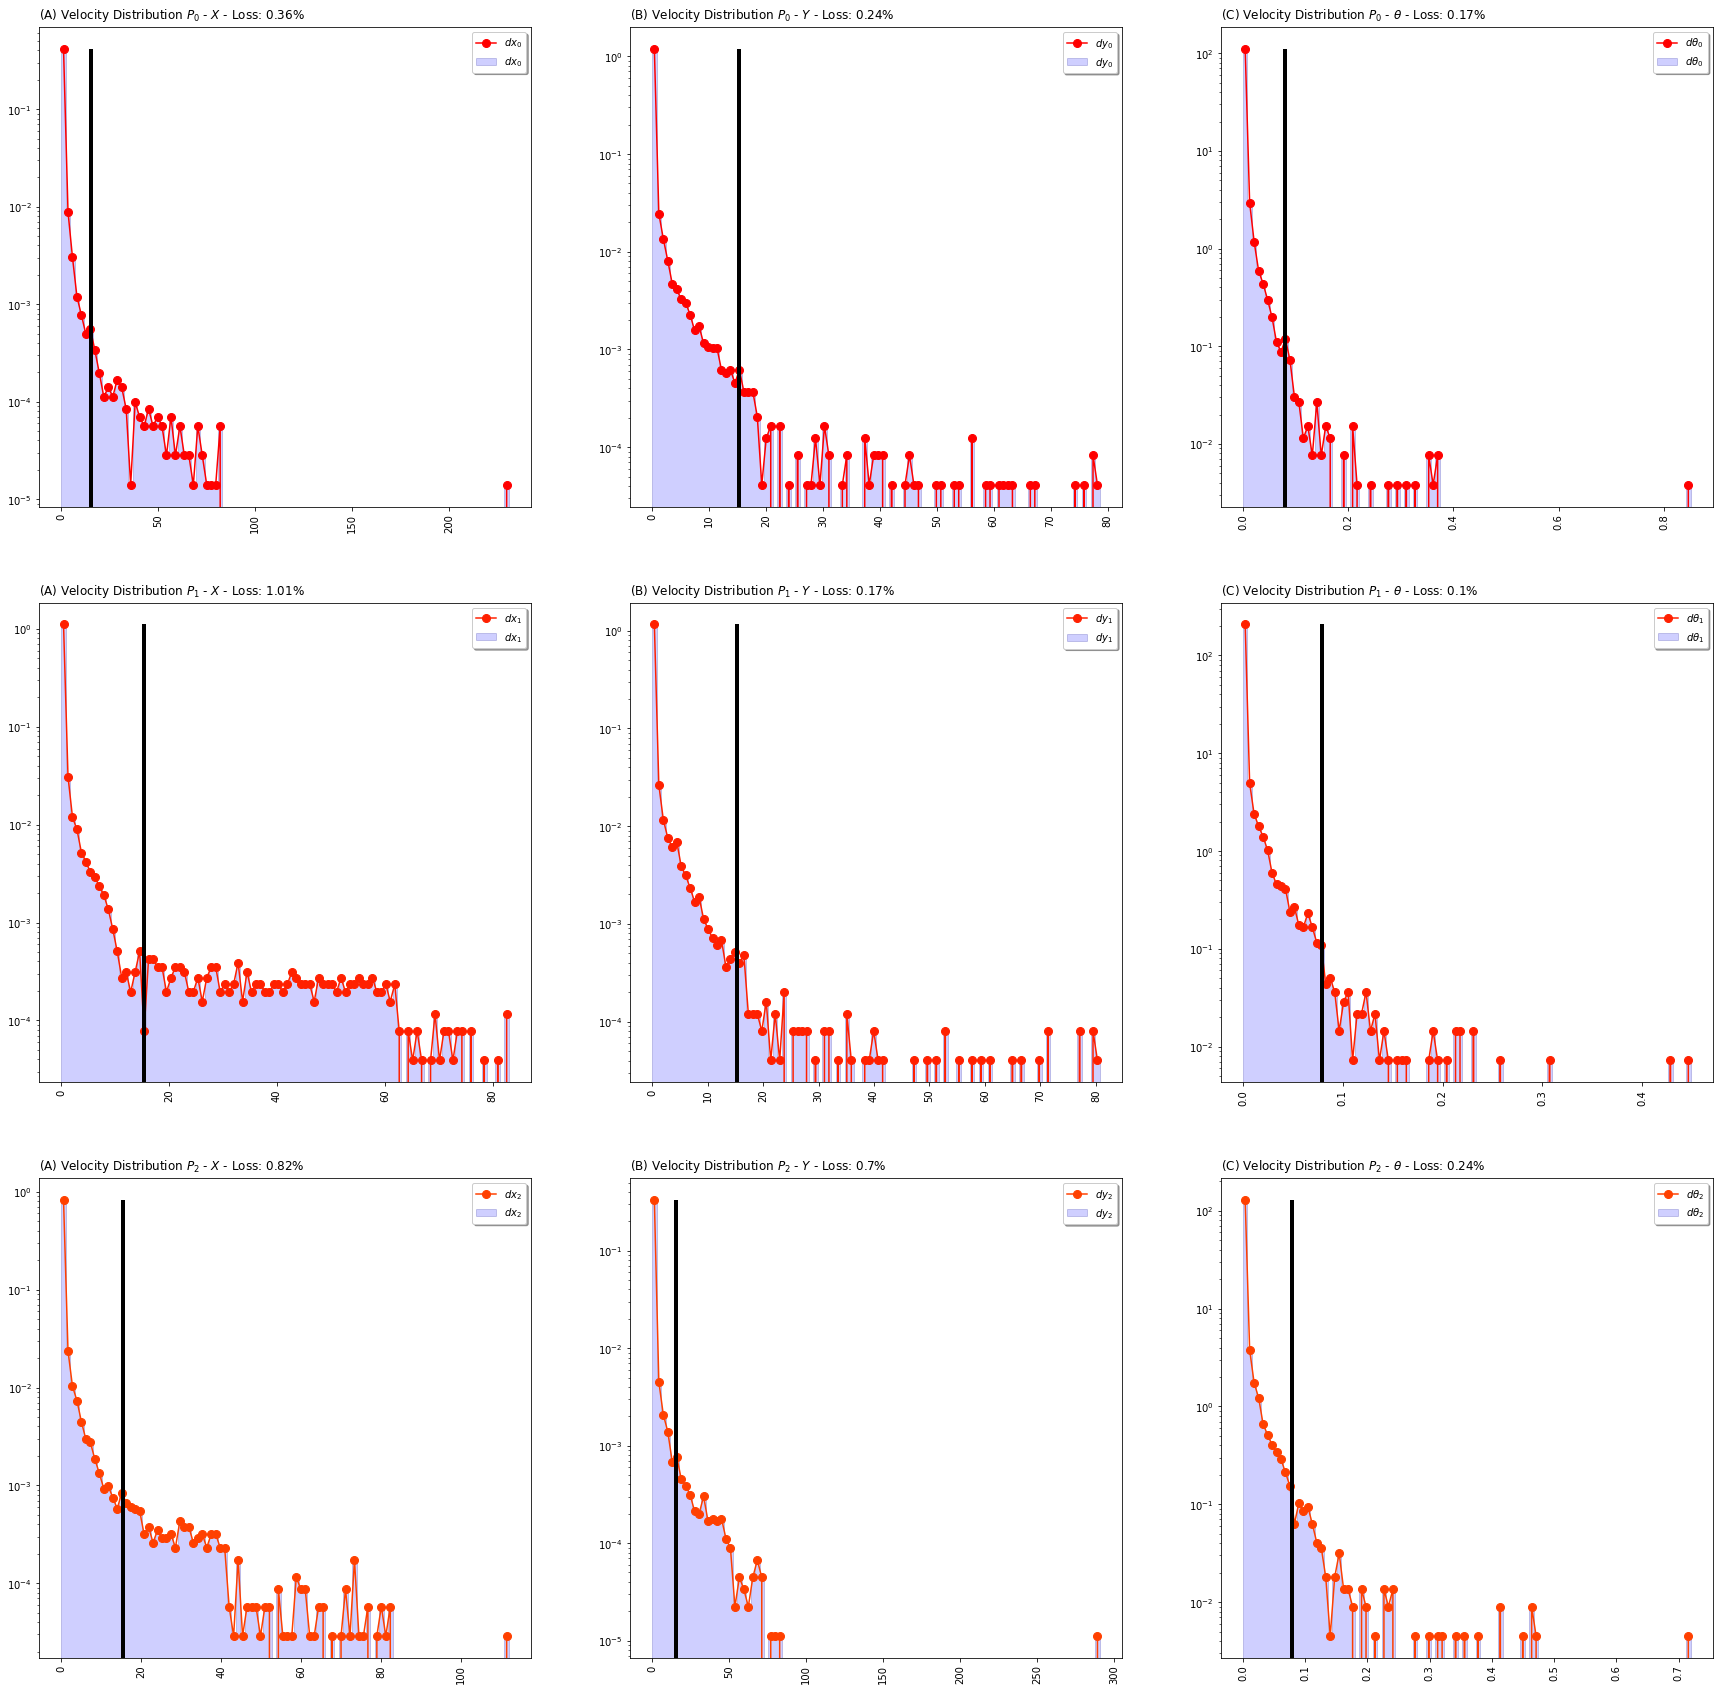

In [10]:
if ordering:
    bins = 100
    width = 10
    fancy_legend = True
    omega_threshold = (
        df_full["velocity_orientation"].abs().quantile(0.9965)
    )  # Angular velocity per frame
    velocity_threshold = (
        df_full["velocity_x"].abs().quantile(0.9901)
    )  # Velocity per frame limited with half average size of particle
    print(
        "Thresholds:\n\t- Velocity:",
        velocity_threshold,
        "\n\t- Angle:",
        omega_threshold * 180 / np.pi,
        "\n",
    )

    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_cp.plot_velocities_distribution(
        df_tracked=df_smooth,
        bins=bins,
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold,
        width=width,
        fancy_legend=fancy_legend,
    )

Original


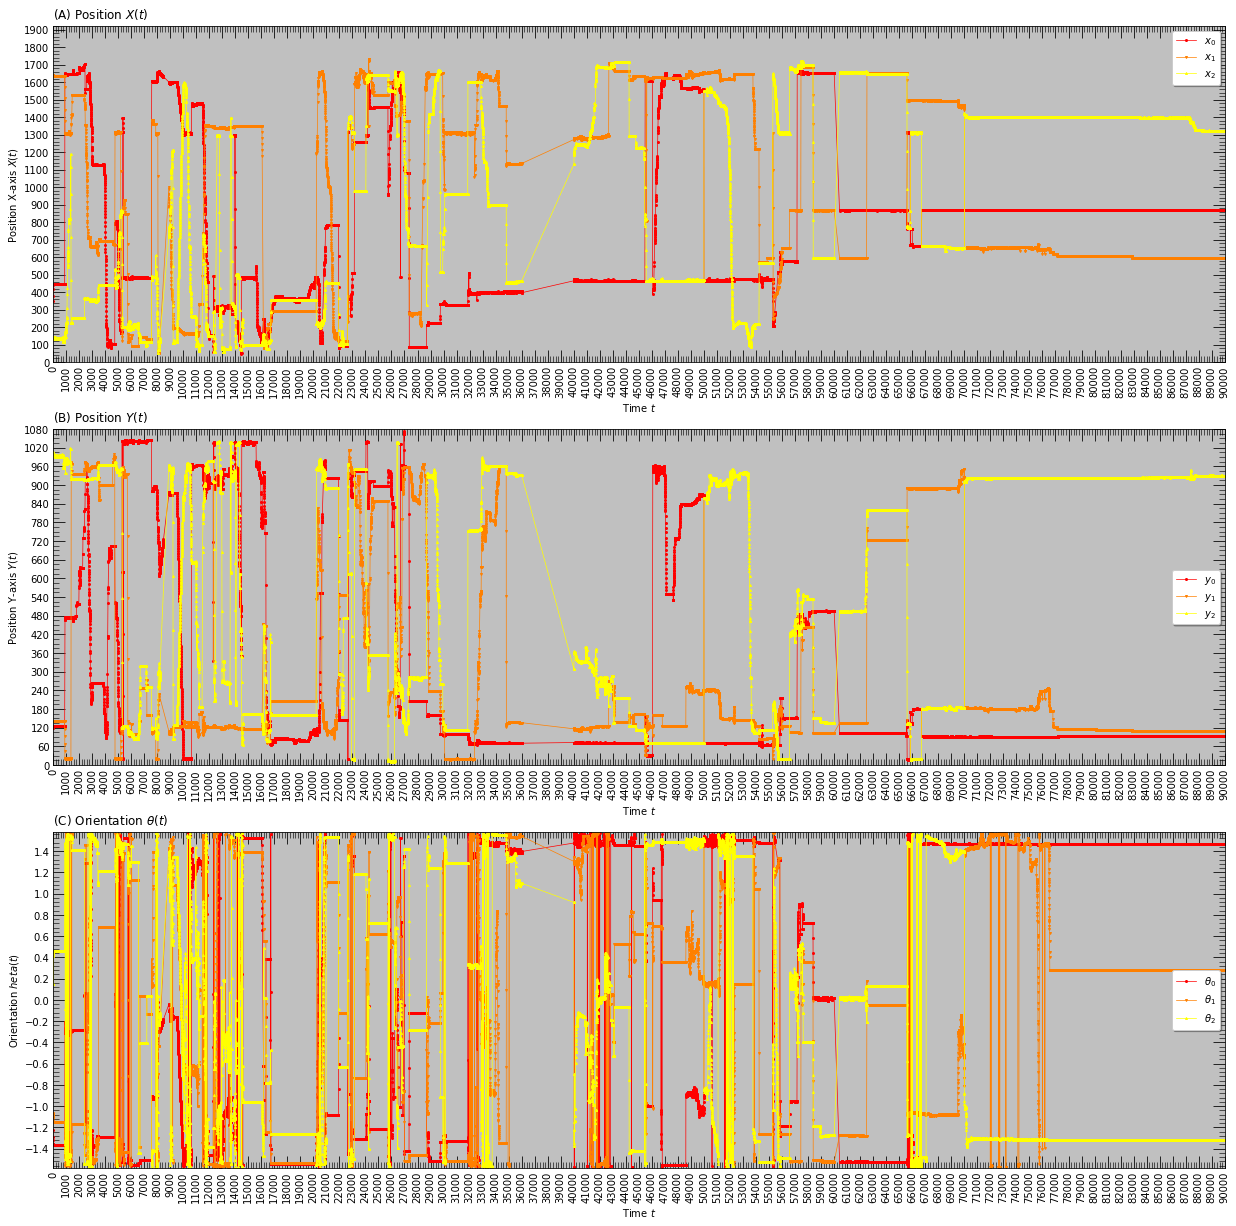

Corrected Orientation


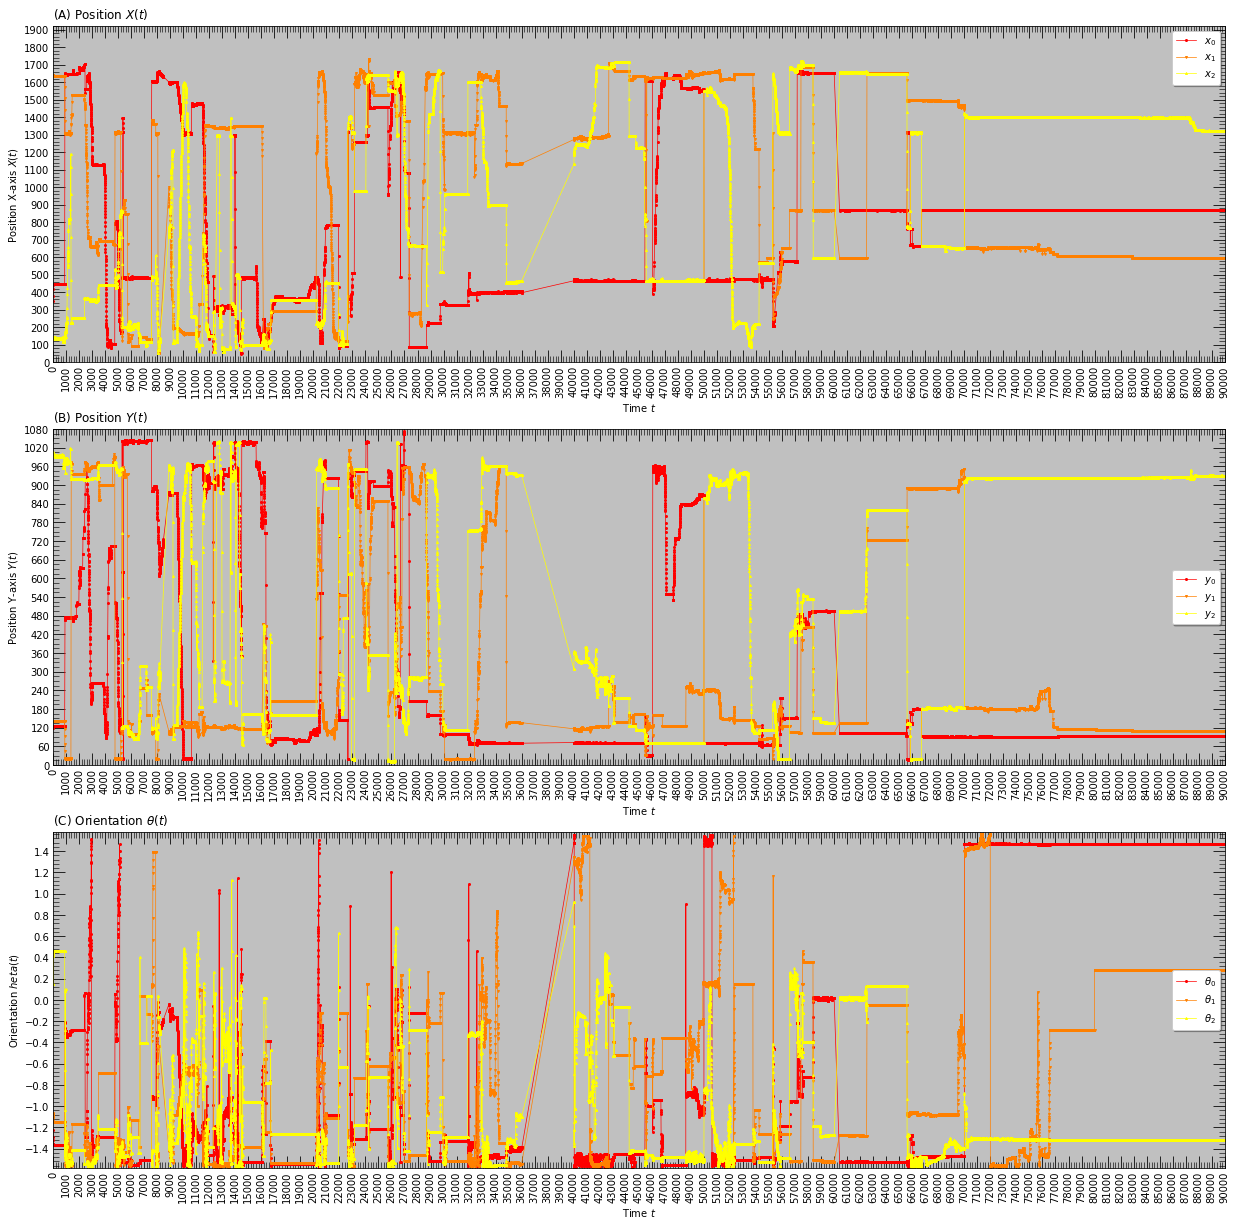

In [11]:
if ordering:
    width = 21
    n_x_breaks = 100
    n_y_breaks = 20
    t0, tf = 0, 90000  # 22200, 24300
    t0_, tf_ = 0, 90000  # 22200, 24300
    t_bounds = [t0_, tf_]
    p_bounds = [[0, 1920], [0, 1080], [-1.58, 1.58]]
    fancy_legend = True

    print("Original")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    velocity_threshold = (
        df_full["velocity_x"].abs().quantile(0.9701)
    )  # Velocity per frame limited with half average size of particle
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[
            (
                (df_smooth["velocity_x"] <= velocity_threshold)
                & (df_smooth["velocity_y"] <= velocity_threshold)
            )
        ],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend,
    )

    print("Corrected Orientation")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[
            (
                (df_smooth["velocity_x"] <= velocity_threshold)
                & (df_smooth["velocity_y"] <= velocity_threshold)
            )
        ],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend,
    )